# Clasificadores generativos vs discriminativos

In [1]:
import numpy as np
from scipy.stats import multinomial, multivariate_normal
import matplotlib.pyplot as plt

## Clasificadores generativos

Los **clasificadores generativos** expresan las **posteriors** en función de **priors** y **densidades condicionales**:
$$p(y=c\mid\boldsymbol{x};\boldsymbol{\theta})=\frac{p(\boldsymbol{x}\mid y=c;\boldsymbol{\theta})\,p(y=c;\boldsymbol{\theta})}{\sum_{c'}p(\boldsymbol{x}\mid y=c';\boldsymbol{\theta})\,p(y=c';\boldsymbol{\theta})}%
\propto p(\boldsymbol{x}\mid y=c;\boldsymbol{\theta})\,p(y=c;\boldsymbol{\theta})$$

El conocimiento de priors y densidades condicionales permite generar datos sintéticos.


**Ejemplo:** $\;C=2$, $\;x\in[0,1]$, $\;\boldsymbol{\theta}$ podría incluir todos o parte de los priors y parámetros de las condicionales, pero en este ejemplo no incluimos ninguno pues suponemos que los conocemos todos
$$\begin{align*}
p(y=1)&=p(y=2)=0.5&&\text{(clases equiprobables)}\\%
p(x\mid y=1)&=0.6\,\mathcal{N}(\mu=0.1, \sigma=0.09)+0.4\,\mathcal{N}(\mu=0.4, \sigma=0.09)%
&&\text{(mixtura de dos normales)}\\%
p(x\mid y=2)&=\mathcal{N}(\mu=0.7, \sigma=0.09)&&\text{(normal)}%
\end{align*}$$

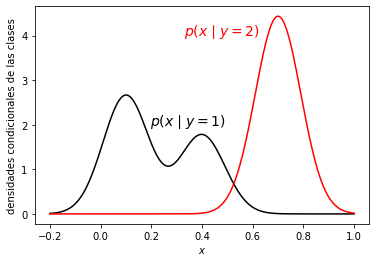

In [13]:
X = np.arange(-0.200, 1.001, 0.001)
def p1(x): return 0.6 * multivariate_normal.pdf(x, 0.1, 0.09**2) + 0.4 * multivariate_normal.pdf(x, 0.4, 0.09**2)
def p2(x): return multivariate_normal.pdf(x, 0.7, 0.09**2)

plt.plot(X, p1(X), '-k', X, p2(X), '-r')
plt.xlabel('$x$')
plt.ylabel('densidades condicionales de las clases')
plt.annotate('$p(x\mid y=1)$', (0.196, 2), fontsize=14)
plt.annotate('$p(x\mid y=2)$', (0.33, 4), fontsize=14, color='red')
plt.show()

Generación de datos sintéticos de acuerdo con la distribución conjunta:
$$\begin{align*}
p(x, y)&=p(y)\,p(x\mid y)&&\text{(primero generamos $y$ y luego $x$ dado $y$)}\\%
p(y)&=\operatorname{Cat}(0.5, 0.5)&&\text{($y$ se genera simulando una categórica)}\\%
p(x\mid y=2)&=\mathcal{N}(0.7, 0.09^2)&&\text{(si $y=2$, $x$ es es un número aleatorio normal)}\\%
\end{align*}$$
La condicional de la clase $1$ puede expresarse en términos de una etiqueta de subclase "perdida", $z\in\{1,2\}$:
$$\begin{align*}
p(x\mid y=1)&=p(x, z=1\mid y=1)+p(x, z=2\mid y=1)\\%
&=p(z=1\mid y=1)\,p(x\mid y=1, z=1)+p(z=2\mid y=1)\,p(x\mid y=1, z=2)\\%
p(z\mid y=1)&=\operatorname{Cat}(0.6, 0.4)\\%
p(x\mid y=1, z=1)&=\mathcal{N}(0.1, 0.09^2)\\%
p(x\mid y=1, z=2)&=\mathcal{N}(0.4, 0.09^2)%
\end{align*}$$

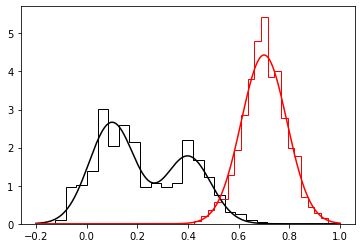

In [53]:
N = 1000
yy = multinomial(1, [0.5, 0.5]).rvs(N)
N1 = yy[yy[:, 0] == 1].shape[0]
zz_y1 = multinomial(1, [0.6, 0.4]).rvs(N1)
N1_y1 = zz_y1[zz_y1[:, 0] == 1].shape[0]
xx_y1_z1 = multivariate_normal(0.1, 0.09**2).rvs(N1_y1)
xx_y1_z2 = multivariate_normal(0.4, 0.09**2).rvs(N1 - N1_y1)
xx_y2 = multivariate_normal(0.7, 0.09**2).rvs(N - N1)
plt.hist(np.hstack((xx_y1_z1, xx_y1_z2)), bins=20, density=True, histtype='step', ec="black")
plt.hist(np.hstack((xx_y2)), bins=20, density=True, histtype='step', ec="red")
plt.plot(X, p1(X), '-k', X, p2(X), '-r');

## Clasificadores discriminativos

Los **clasificadores discriminativos** modelan **posteriors** directamente sin explicar cómo generar $\boldsymbol{x}$ por cada $c$:
$$p(y=c\mid\boldsymbol{x};\boldsymbol{\theta})=\cdots$$

**Ejemplo (cont.):**
$$\begin{align*}
p(y=1\mid\boldsymbol{x})&=\frac{1}{1+\exp(27x-15)}\\%
p(y=2\mid\boldsymbol{x})&=\frac{1}{1+\exp(-27x+15)}%
\end{align*}$$

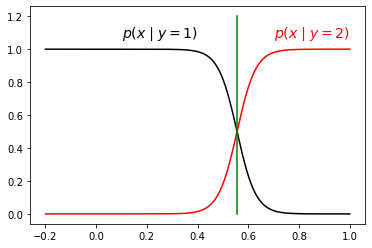

In [62]:
def p1(x): return 1/(1 + np.exp((27*x-15)))
def p2(x): return 1/(1 + np.exp((-27*x+15)))

plt.plot(X, p1(X), '-k')
plt.plot(X, p2(X), '-r')
plt.plot([0.556, 0.556], [0, 1.2], '-g')
plt.annotate('$p(x\mid y=1)$', (0.1, 1.07), fontsize=14)
plt.annotate('$p(x\mid y=2)$', (0.7, 1.07), fontsize=14, color='red');

**Ventajas de los clasificadores discriminativos**

* **Mejor precisión predictiva:** pues $p(y\mid\boldsymbol{x})$ suele ser más fácil de aprender y no deben "malgastar esfuerzos" modelando la distribución de los datos
* **Facilitan el preproceso de características:** por ejemplo, mediante expansión polinómica del vector de características, cosa complicada de hacer con generativos pues las nuevas características pueden exhibir correlaciones complejas difíciles de modelar
* **Probabilidades bien calibradas:** algunos generativos, por ejemplo naive Bayes, se basan en asunciones poco realistas que suelen conducir a posteriors extremas; sin embargo, los discriminativos, por ejemplo regresión logística, suelen estar mejor calibrados en términos de estimación de posteriors

**Ventajas de los clasificadores generativos**
* **Fáciles de ajustar:** usualmente mediante conteo y promediado; en contraste, regresión logística requiere resolver un problema de optimización convexo, y las redes neuronales uno no convexo, lo que se traduce en procesos computacionalmente muy costosos
* **Facilitan el tratamiento de datos perdidos:** gracias al modelado de condicionales, cosa que en los discriminativos no es posible
* **Pueden ajustar clases separadamente:** por lo general es así, lo que permite añadir nuevas clases sin reentrenar las demás
* **Pueden aprovechar datos de entrenamiento no etiquetados:** para aprendizaje semi-supervisado (difícil con discriminativos)
* **Pueden ser más robustos frente a características espúrias (degeneradas):** al capturar los mecanismos causales del proceso generativo subyacente